In [285]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from matplotlib.colors import to_rgba

from sklearn import datasets as sklearn_datas

from tqdm.notebook import tqdm

In [2]:
import caspailleur as csp
from paspailleur import pattern_structures as PS

In [3]:
from bitarray.util import subset as ba_subset
from bitarray import frozenbitarray

# Get the data

In [39]:
datasets = dict()

In [40]:
n_samples = 500
seed = 30
random_state = 170

In [41]:
# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
datasets['noisy_circles'] = sklearn_datas.make_circles(
    n_samples=n_samples, factor=0.5, noise=0.05, random_state=seed)

In [42]:
# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
datasets['noisy_moons'] = sklearn_datas.make_moons(n_samples=n_samples, noise=0.05, random_state=seed)

In [43]:
datasets['varied'] = sklearn_datas.make_blobs(n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=170)

In [44]:
X, y = sklearn_datas.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
datasets['aniso'] = X_aniso, y

In [45]:
datasets['blobs'] = sklearn_datas.make_blobs(n_samples=n_samples, random_state=seed)

In [46]:
rng = np.random.RandomState(seed)
datasets['no_structure'] = rng.rand(n_samples, 2), None

In [56]:
datasets_scaled = {k: (StandardScaler().fit_transform(X), y)
                   for k, (X, y) in datasets.items()}

# Get SotA clusterings

In [47]:
default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 3,
    "n_clusters": 3,
    "min_samples": 7,
    "xi": 0.05,
    "min_cluster_size": 0.1,
    "allow_single_cluster": True,
    "hdbscan_min_cluster_size": 15,
    "hdbscan_min_samples": 3,
    "random_state": 42,
}

In [48]:
dataset_params = {
    'noisy_circles': {
        "damping": 0.77,
        "preference": -240,
        "quantile": 0.2,
        "n_clusters": 2,
        "min_samples": 7,
        "xi": 0.08,
    },
    'noisy_moons': {
        "damping": 0.75,
        "preference": -220,
        "n_clusters": 2,
        "min_samples": 7,
        "xi": 0.1,
    },
    'varied': {
        "eps": 0.18,
        "n_neighbors": 2,
        "min_samples": 7,
        "xi": 0.01,
        "min_cluster_size": 0.2,
    },
    'aniso': {
        "eps": 0.15,
        "n_neighbors": 2,
        "min_samples": 7,
        "xi": 0.1,
        "min_cluster_size": 0.2,
    },
    'blobs': {"min_samples": 7, "xi": 0.1, "min_cluster_size": 0.2},
    'no_structure': dict()
}

In [49]:
from sklearn.preprocessing import StandardScaler
from sklearn import cluster, mixture

In [64]:
type(k_means).__name__, type(dbscan).__name__, type(optics).__name__

('KMeans', 'DBSCAN', 'OPTICS')

In [79]:
k_means.cluster_centers_

array([[ 0.96795883, -0.59683117],
       [-0.0410921 ,  1.0369476 ],
       [-0.91017484, -0.70659558]])

In [80]:
from datetime import datetime

In [282]:
cluster_data_out = dict()

In [283]:
for i_dataset, data_name in enumerate(datasets):
    params = dict(default_base, **dataset_params[data_name])
    X, _ = datasets_scaled[data_name]
    
    k_means = cluster.KMeans(
        n_clusters=params["n_clusters"],
        random_state=params["random_state"],
    )
    dbscan = cluster.DBSCAN(eps=params["eps"])
    optics = cluster.OPTICS(
        min_samples=params["min_samples"],
        xi=params["xi"],
        min_cluster_size=params["min_cluster_size"],
    )
    
    for algo in [k_means, dbscan, optics]:
        t1 = datetime.now()
        algo.fit(X)
        t2 = datetime.now()
        cluster_data_out[(type(algo).__name__, data_name)] = {
            'labels': algo.labels_, 'fitting_time': (t2-t1).total_seconds()
        }
        
    cluster_data_out[(type(k_means).__name__, data_name)]['centroids'] = k_means.cluster_centers_
        
print(cluster_data_out.keys())

dict_keys([('KMeans', 'noisy_circles'), ('DBSCAN', 'noisy_circles'), ('OPTICS', 'noisy_circles'), ('KMeans', 'noisy_moons'), ('DBSCAN', 'noisy_moons'), ('OPTICS', 'noisy_moons'), ('KMeans', 'varied'), ('DBSCAN', 'varied'), ('OPTICS', 'varied'), ('KMeans', 'aniso'), ('DBSCAN', 'aniso'), ('OPTICS', 'aniso'), ('KMeans', 'blobs'), ('DBSCAN', 'blobs'), ('OPTICS', 'blobs'), ('KMeans', 'no_structure'), ('DBSCAN', 'no_structure'), ('OPTICS', 'no_structure')])


# Fit FCA clusterings

In [96]:
from icecream import ic

In [139]:
from script import clustering as clib
from script import visual_lib as vlib

In [189]:
from importlib import reload
clib = reload(clib)

In [164]:
MIN_CLUSTER_SUPPORT = 10
MIN_DELTA_STABILITY = 5
MIN_ADDED_COVERAGE = 75
MIN_CLUSTER_SUPPORT = max(MIN_CLUSTER_SUPPORT, MIN_ADDED_COVERAGE, MIN_DELTA_STABILITY)

MIN_TOTAL_COVERAGE = 450
N_CLUSTERS_MAX = 3

In [607]:
WEIGHT_PARAMS = dict(
    overlap_weight=2,
    size_weight=0.1, # old "n_concepts_weight"
    imbalance_weight=3,
    stability_weight=1,
    complexity_weight=0.1,
    density_weight=5
)

In [336]:
def mine_fca_clustering(X):
    stats = dict()

    t1 = datetime.now()
    linscale_x = np.linspace(X[:,0].min()-0.01, X[:,0].max()+0.01, 11)
    linscale_y = np.linspace(X[:,1].min()-0.01, X[:,1].max()+0.01, 11)

    ps = PS.CartesianPS([PS.IntervalPS(values=linscale_x), PS.IntervalPS(values=linscale_y)])
    data = list(ps.preprocess_data(X))
    
    attributes, attr_extents = zip(*ps.iter_attributes(data, min_support=MIN_CLUSTER_SUPPORT))
    t2 = datetime.now()
    stats['n_attributes'] = len(attr_extents)
    stats['time_step1'] = (t2-t1).total_seconds()
    ic(stats['n_attributes'], stats['time_step1'])
    
    
    t1 = datetime.now()
    stable_extents = csp.mine_equivalence_classes.list_stable_extents_via_gsofia(
        attr_extents,
        n_objects=len(data), min_delta_stability=MIN_DELTA_STABILITY, min_supp=MIN_CLUSTER_SUPPORT,
        use_tqdm=True, n_attributes=len(attributes)
    )
    stable_extents = sorted(stable_extents, key=lambda ext: ext.count(), reverse=True)
    t2 = datetime.now()
    stats['n_stables'] = len(stable_extents)
    stats['time_step2'] = (t2-t1).total_seconds()
    ic(stats['n_stables'], stats['time_step2'])
    
    
    t1 = datetime.now()
    clusterings = list(clib.mine_clusterings(
        stable_extents,
        min_support=MIN_TOTAL_COVERAGE, max_length=N_CLUSTERS_MAX, min_added_coverage=MIN_ADDED_COVERAGE
    ))
    t2 = datetime.now()
    stats['n_clusterings'] = len(clusterings)
    stats['time_step3'] = (t2-t1).total_seconds()
    ic(stats['n_clusterings'], stats['time_step3'])
    
    t1 = datetime.now()
    concepts_dict = clib.mine_clusters_info(stable_extents, attr_extents, ps, data)
    clusterings_df = pd.DataFrame(
        [clib.evaluate_clustering_measures(idxs, concepts_dict) for idxs in clusterings],
        index=pd.Series(clusterings, name='clustering')
    )
    clusterings_df_norm = (clusterings_df-clusterings_df.min())/(clusterings_df.max()-clusterings_df.min())
    clusterings_df_norm.describe().loc[['min', 'max']]
    
    signs = np.array([1 if f in {'coverage', 'stability', 'density'} else -1 for f in clusterings_df_norm])
    weights = np.array([1 if f == 'coverage' else WEIGHT_PARAMS[f"{f}_weight"] for f in clusterings_df_norm])
    clusterings_df['reward'] = (clusterings_df_norm*weights*signs).sum(1)
    clusterings_df = clusterings_df.sort_values('reward', ascending=False)
    t2 = datetime.now()
    
    stats['time_step4'] = (t2-t1).total_seconds()
    stats['fitting_time'] = sum(stats[f'time_step{i}'] for i in range(1, 5))
        
    return clusterings_df, concepts_dict, stats

In [251]:
def extract_hypercubes(clustering: list[int], concepts_dict: dict[str, list[float]]) -> list[np.ndarray]:
    return [np.array([intrv[:2] for intrv in concepts_dict['intent'][cluster_id]]) for cluster_id in clustering]

In [277]:
def predict_with_hypercubes(X: np.ndarray, hypercubes: list[np.ndarray]) -> np.ndarray:
    labels = np.ones(len(X), dtype=int)*-1
    for i, hcube in enumerate(hypercubes):
        extent = ((hcube[:,0] <= X)& (X <= hcube[:,1])).all(1)
        labels[extent] = i
    return labels

In [608]:
for i_dataset, data_name in tqdm(enumerate(datasets), total=len(datasets)):
    ic(data_name)
    X, _ = datasets_scaled[data_name]
    
    clusterings_df, concepts_dict, fca_stats = mine_fca_clustering(X)
#    best_clustering = clusterings_df[clusterings_df['overlap']==0].index[0]
    best_clustering = clusterings_df[(clusterings_df['overlap']==0)&(clusterings_df['size']==3)].index[0]
    hypercubes = extract_hypercubes(best_clustering, concepts_dict)
    
    cluster_data_out[('FCA', data_name)] = {
        'labels': predict_with_hypercubes(X, hypercubes),
        'hypercubes': hypercubes,
        **fca_stats
    }
    ic()
    
print(cluster_data_out.keys())

  0%|          | 0/6 [00:00<?, ?it/s]

ic| data_name: 'noisy_circles'
ic| stats['n_attributes']: 30, stats['time_step1']: 0.033129


  0%|          | 0/30 [00:00<?, ?it/s]

ic| stats['n_stables']: 1150, stats['time_step2']: 0.022637
ic| stats['n_clusterings']: 129629, stats['time_step3']: 84.734513
ic| 1150654445.py:15 in <module> at 17:43:00.955
ic| data_name: 'noisy_moons'
ic| stats['n_attributes']: 34, stats['time_step1']: 0.023846


  0%|          | 0/34 [00:00<?, ?it/s]

ic| stats['n_stables']: 636, stats['time_step2']: 0.016548
ic| stats['n_clusterings']: 99082, stats['time_step3']: 15.862467
ic| 1150654445.py:15 in <module> at 17:43:19.992
ic| data_name: 'varied'
ic| stats['n_attributes']: 33, stats['time_step1']: 0.024163


  0%|          | 0/33 [00:00<?, ?it/s]

ic| stats['n_stables']: 564, stats['time_step2']: 0.013471
ic| stats['n_clusterings']: 71696, stats['time_step3']: 8.769107
ic| 1150654445.py:15 in <module> at 17:43:31.105
ic| data_name: 'aniso'
ic| stats['n_attributes']: 31, stats['time_step1']: 0.022532


  0%|          | 0/31 [00:00<?, ?it/s]

ic| stats['n_stables']: 342, stats['time_step2']: 0.008298
ic| stats['n_clusterings']: 21353, stats['time_step3']: 1.548078
ic| 1150654445.py:15 in <module> at 17:43:33.678
ic| data_name: 'blobs'
ic| stats['n_attributes']: 31, stats['time_step1']: 0.022415


  0%|          | 0/31 [00:00<?, ?it/s]

ic| stats['n_stables']: 554, stats['time_step2']: 0.013339
ic| stats['n_clusterings']: 51796, stats['time_step3']: 7.171202
ic| 1150654445.py:15 in <module> at 17:43:43.287
ic| data_name: 'no_structure'
ic| stats['n_attributes']: 34, stats['time_step1']: 0.023624


  0%|          | 0/34 [00:00<?, ?it/s]

ic| stats['n_stables']: 1139, stats['time_step2']: 0.026069
ic| stats['n_clusterings']: 96914, stats['time_step3']: 84.184313
ic| 1150654445.py:15 in <module> at 17:45:10.767


dict_keys([('KMeans', 'noisy_circles'), ('DBSCAN', 'noisy_circles'), ('OPTICS', 'noisy_circles'), ('KMeans', 'noisy_moons'), ('DBSCAN', 'noisy_moons'), ('OPTICS', 'noisy_moons'), ('KMeans', 'varied'), ('DBSCAN', 'varied'), ('OPTICS', 'varied'), ('KMeans', 'aniso'), ('DBSCAN', 'aniso'), ('OPTICS', 'aniso'), ('KMeans', 'blobs'), ('DBSCAN', 'blobs'), ('OPTICS', 'blobs'), ('KMeans', 'no_structure'), ('DBSCAN', 'no_structure'), ('OPTICS', 'no_structure'), ('FCA', 'noisy_circles'), ('FCA', 'noisy_moons'), ('FCA', 'varied'), ('FCA', 'aniso'), ('FCA', 'blobs'), ('FCA', 'no_structure')])


In [609]:
import json

In [610]:
import pickle

In [621]:
with open('clustering_stats.pickle', 'wb') as file:
    pickle.dump(cluster_data_out, file)

# Visualise Figure 2

In [611]:
dataset_params.keys()

dict_keys(['noisy_circles', 'noisy_moons', 'varied', 'aniso', 'blobs', 'no_structure'])

In [612]:
cluster_data_out.keys()

dict_keys([('KMeans', 'noisy_circles'), ('DBSCAN', 'noisy_circles'), ('OPTICS', 'noisy_circles'), ('KMeans', 'noisy_moons'), ('DBSCAN', 'noisy_moons'), ('OPTICS', 'noisy_moons'), ('KMeans', 'varied'), ('DBSCAN', 'varied'), ('OPTICS', 'varied'), ('KMeans', 'aniso'), ('DBSCAN', 'aniso'), ('OPTICS', 'aniso'), ('KMeans', 'blobs'), ('DBSCAN', 'blobs'), ('OPTICS', 'blobs'), ('KMeans', 'no_structure'), ('DBSCAN', 'no_structure'), ('OPTICS', 'no_structure'), ('FCA', 'noisy_circles'), ('FCA', 'noisy_moons'), ('FCA', 'varied'), ('FCA', 'aniso'), ('FCA', 'blobs'), ('FCA', 'no_structure')])

In [613]:
data_order = ['noisy_circles', 'noisy_moons', 'varied', 'aniso', 'blobs', 'no_structure']
algo_order = ['FCA', 'KMeans', 'DBSCAN', 'OPTICS']

assert [(algo, data) for algo in algo_order for data in data_order if (algo, data) not in cluster_data_out] == []

In [614]:
from matplotlib.cm import get_cmap

In [617]:
from itertools import cycle, islice


def init_palette(n_clusters):
    colors = [
        "#377eb8", "#ff7f00",        "#4daf4a",        "#f781bf",        "#a65628",        "#984ea3",
        "#999999",        "#e41a1c",        "#dede00",
    ] # default scikit learn
    colors = ['goldenrod', 'navy', 'green'] #['royalblue', 'goldenrod', 'maroon']
#    colors = ['tab:blue', 'tab:red', 'tab:green']
    colors = list(islice(cycle(colors), n_clusters)) + ['dimgray']
    return np.array(colors)

/var/folders/28/jmw8nj2d5p9crv64k2tq98400000gn/T/ipykernel_94349/470196344.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(len(datasets), len(algo_order), plot_num)


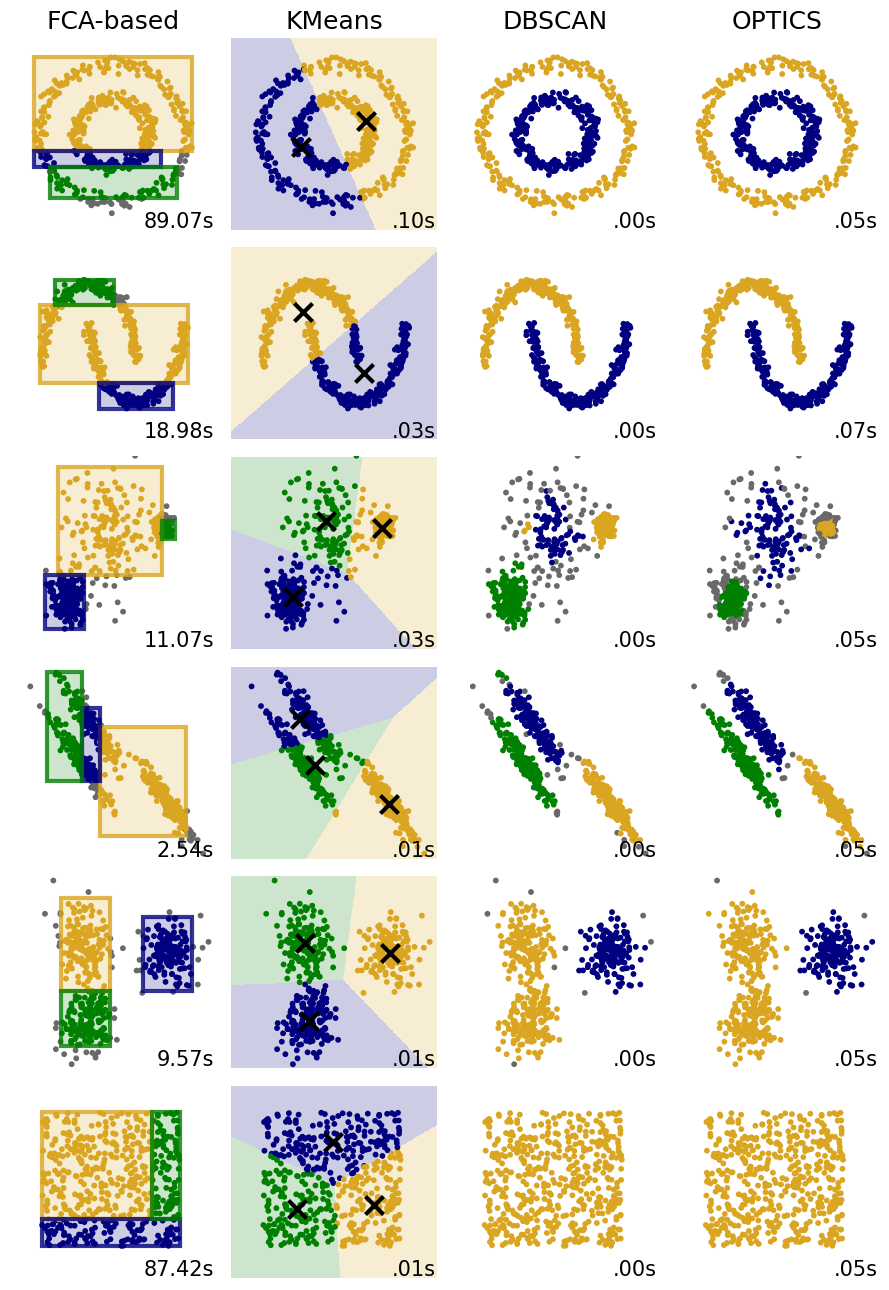

In [620]:
plt.figure(figsize=(2*3+3, 13))
plt.box(False)
plt.subplots_adjust(left=0.0, right=1, bottom=0, top=1, wspace=0.1, hspace=0.1)

plot_num = 1
for i_data, data_name in enumerate(data_order):
    X, _ = datasets_scaled[data_name]
    
    for algo_name in algo_order:
        ax = plt.subplot(len(datasets), len(algo_order), plot_num)
        fig.patch.set_visible(False)
        ax.axis('off'); plt.xlim(-2.5, 2.5); plt.ylim(-2.5, 2.5)
        
        if i_data == 0:
            plt.title(algo_name if algo_name != 'FCA' else 'FCA-based', size=18)
            
        labels = cluster_data_out[(algo_name, data_name)]['labels'].copy()
        n_clusters = max(labels)+1
        cmap = ListedColormap(init_palette(n_clusters))
#        cmap = get_cmap('Dark2', n_clusters+1)
#        cmap.set_over('dimgray')

        labels[labels==-1] = n_clusters
    
        dt = cluster_data_out[(algo_name, data_name)]['fitting_time']
        
        
        plt.scatter(X[:, 0], X[:, 1], s=10, c=labels, cmap=cmap, vmin=0, vmax=n_clusters)
        plt.text(0.99,0.01,("%.2fs" % dt).lstrip("0"), transform=plt.gca().transAxes,size=15, horizontalalignment="right",)
        
        if algo_name in {'KMeans', 'FCA'}:
            h = 0.02
            x_min, x_max = -2.5, 2.5  # X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
            y_min, y_max = -2.5, 2.5  # X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
            xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
            backdots = np.c_[xx.ravel(), yy.ravel()]
            
            cmap_back = cmap.copy()
            if algo_name == 'KMeans':
                centroids = cluster_data_out[(algo_name, data_name)]['centroids']
                plt.scatter(centroids[:, 0], centroids[:, 1],
                     marker="x", s=169, linewidths=3, color="black", zorder=10)
                Z = np.vstack([((backdots-centroid)**2).sum(1) for centroid in centroids]).argmin(0)

            if algo_name == 'FCA':
                hypercubes = cluster_data_out[(algo_name, data_name)]['hypercubes']
                Z = predict_with_hypercubes(backdots, hypercubes)
                Z[Z==-1] = len(hypercubes)+10
                cmap_back.set_over(alpha=0)
                
                for i, hcube in enumerate(hypercubes):
                    descr = [(a,b) for (a, b) in hcube]
                    vlib.draw_2d_description(
                        ax, descr,
                        patch_params={
                            'fc':to_rgba('purple', 0), 'ec':to_rgba(cmap(i), 0.8), 'linewidth':3, 'zorder':1})
                
                
            Z = Z.reshape(xx.shape)
            plt.imshow(
                Z,
                interpolation="nearest",
                extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                cmap=cmap_back, vmin=0, vmax=n_clusters,
                aspect="auto",
                origin="lower", zorder=0, alpha=0.2
            )
                
        plot_num += 1
plt.tight_layout()        
plt.savefig('../figures/all_clusters_per_algo_data.pdf')
plt.savefig('../figures/all_clusters_per_algo_data2.png')

# FCA running time table

In [698]:
time_df = pd.DataFrame({data_name:
    pd.Series(cluster_data_out[('FCA', data_name)])[[
        'time_step1', 'n_stables', 'time_step2', 'n_clusterings', 'time_step3', 'time_step4', 'fitting_time'
    ]] for data_name in data_order
}).T

In [699]:
time_df = time_df.astype({f: float if 'time' in f else int for f in time_df.columns})

In [700]:
time_df['time_step2'] = time_df['time_step1'] + time_df['time_step2']
time_df = time_df.drop(columns=['time_step1'])

In [701]:
time_df = time_df.round(2)

In [702]:
time_df.columns = pd.MultiIndex.from_tuples([{
    'n_stables': ('Step 2: Enumerate Cluster Candidates', '# stable concepts'),
    'time_step2': ('Step 2: Enumerate Cluster Candidates', 'time (s)'),
    'n_clusterings': ('Step 3: Enumerate Clusterings', '# clusterings'),
    'time_step3': ('Step 3: Enumerate Clusterings', 'time (s)'),
    'time_step4': ('Step 4: Compute Statistics', 'time (s)'),
    'fitting_time': ('Full pipeline', 'time (s)')
}[f] for f in time_df.columns])

In [703]:
time_df

Step 2: Enumerate Cluster Candidates           \
                                 # stable concepts time (s)   
noisy_circles                                 1150     0.06   
noisy_moons                                    636     0.04   
varied                                         564     0.04   
aniso                                          342     0.03   
blobs                                          554     0.04   
no_structure                                  1139     0.05   

              Step 3: Enumerate Clusterings           \
                              # clusterings time (s)   
noisy_circles                        129629    84.73   
noisy_moons                           99082    15.86   
varied                                71696     8.77   
aniso                                 21353     1.55   
blobs                                 51796     7.17   
no_structure                          96914    84.18   

              Step 4: Compute Statistics Full pipeline  
                                time (s)      time (s)  
noisy_circles                       4.28         89.07  
noisy_moons                         3.08         18.98  
varied                              2.26         11.07  
aniso                               0.96          2.54  
blobs                               2.37          9.57  
no_structure                        3.19         87.42

In [704]:
time_df.to_csv('../timing_4oct.csv')

In [705]:
print(time_df.to_latex(float_format='%.2f'))

\begin{tabular}{lrrrrrr}
\toprule
 & \multicolumn{2}{r}{Step 2: Enumerate Cluster Candidates} & \multicolumn{2}{r}{Step 3: Enumerate Clusterings} & Step 4: Compute Statistics & Full pipeline \\
 & # stable concepts & time (s) & # clusterings & time (s) & time (s) & time (s) \\
\midrule
noisy_circles & 1150 & 0.06 & 129629 & 84.73 & 4.28 & 89.07 \\
noisy_moons & 636 & 0.04 & 99082 & 15.86 & 3.08 & 18.98 \\
varied & 564 & 0.04 & 71696 & 8.77 & 2.26 & 11.07 \\
aniso & 342 & 0.03 & 21353 & 1.55 & 0.96 & 2.54 \\
blobs & 554 & 0.04 & 51796 & 7.17 & 2.37 & 9.57 \\
no_structure & 1139 & 0.05 & 96914 & 84.18 & 3.19 & 87.42 \\
\bottomrule
\end{tabular}

